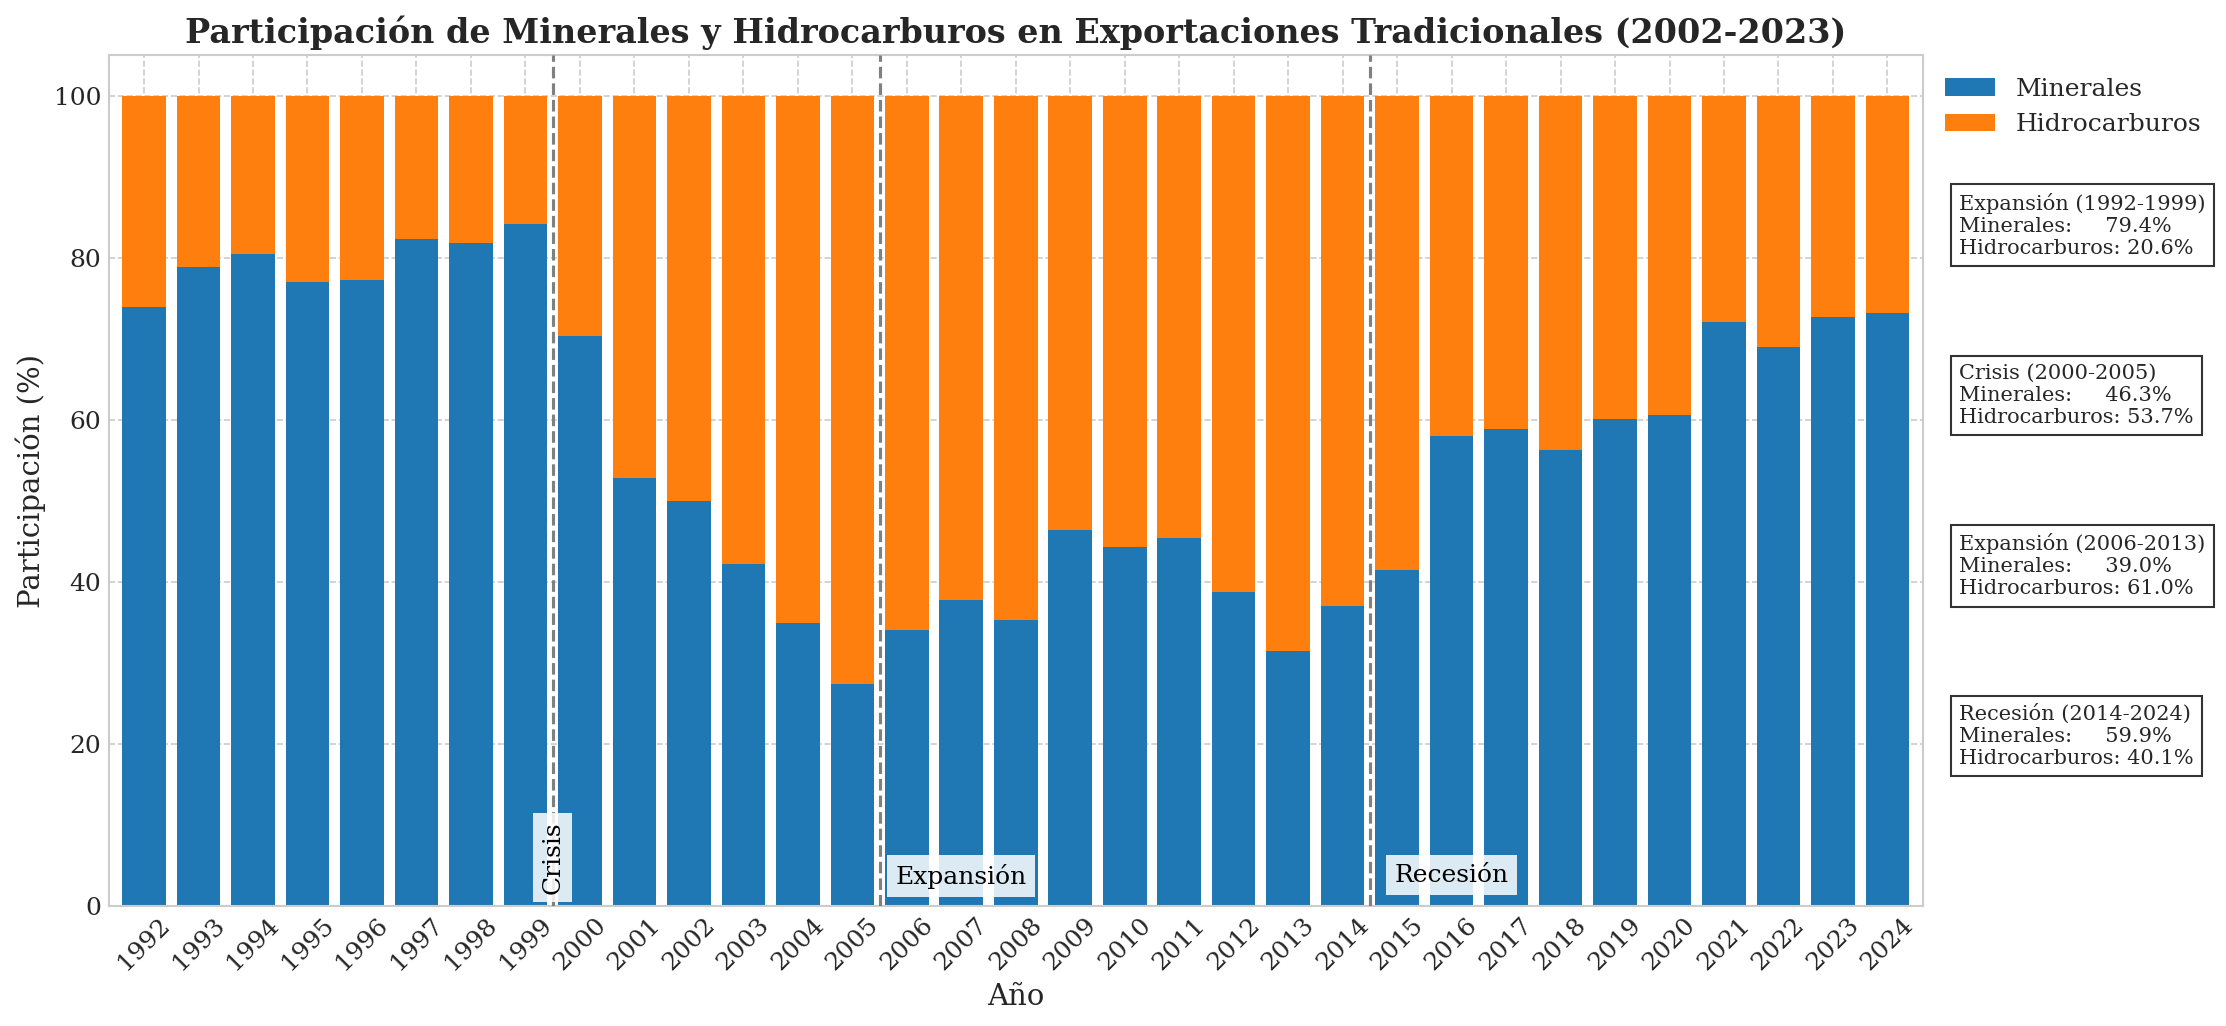

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os

# ── 1. Parámetros y rutas ─────────────────────────────────────────────────────
PRE_CRISIS_YEARS=slice(1992, 1999)  
CRISIS_YEARS = slice(2000, 2005)            # 2002-2005 inclusive
POST_YEARS   = slice(2006, 2014)            # 2006-2023 inclusive
RECESION_YEARS =slice(2014, 2024) 
OUTPUT_DIR   = "../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── 2. Estilo profesional ─────────────────────────────────────────────────────
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 16, "axes.labelsize": 14,
    "grid.linestyle": "--", "lines.linewidth": 2,
    "figure.dpi": 150, "savefig.bbox": "tight"
})

# ── 3. Carga de datos ─────────────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = pd.read_sql_query("SELECT * FROM exportaciones_tradicionales", conn)

df.set_index("año", inplace=True)            # ajusta si tu tabla llega a 2024+

# ── 4. Cálculo de participaciones (%) ─────────────────────────────────────────
df["total"] = df["minerales"] + df["hidrocarburos"]
pct = df[["minerales", "hidrocarburos"]].div(df["total"], axis=0) * 100

# ── 5. Estadísticas promedio por periodo ──────────────────────────────────────
avg_pre_crisis=pct.loc[PRE_CRISIS_YEARS].mean()
avg_crisis = pct.loc[CRISIS_YEARS].mean()
avg_post   = pct.loc[POST_YEARS].mean()
avg_recesion=pct.loc[RECESION_YEARS].mean()

# ── 6. Gráfico stacked-bar ────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 7))
pct.plot(kind="bar", stacked=True, ax=ax, width=0.8)

ax.set_ylabel("Participación (%)")
ax.set_xlabel("Año")
ax.set_title(
    "Participación de Minerales y Hidrocarburos en Exportaciones Tradicionales (2002-2023)",
    fontweight="bold"
)
ax.legend(["Minerales", "Hidrocarburos"], loc="upper left",
          bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)

# ── 6.5. Líneas verticales y texto de hitos (posición basada en índice) ────
hitos_offset = {
    1999: (0, 0.10),
    2005: (1.5, 0.05),
    2014: (1.5, 0.05)
}

# asegúrate de ajustar márgenes antes de tight_layout
fig.subplots_adjust(right=0.8)

# ── 5.1 Hitos visuales ─────────────────────────────────────────────────────
hitos_v = {
    1999: "Crisis",
    2005: "Expansión",
    2014: "Recesión"
}
fig.subplots_adjust(right=0.72)

for yr, lbl in hitos_v.items():
    if yr in pct.index:
        idx = pct.index.get_loc(yr)
        y_max=ax.get_ylim()[1]
        ax.axvline(
            x=idx + 0.5, color="gray", ls="--", lw=1.5, zorder=5
        )
        dx,dy=hitos_offset.get(yr,(0,0.5))
        ax.text(
            idx + 0.5+dx,dy, lbl, rotation=0 if lbl=='Expansión' or lbl=='Recesión' else 90, ha="center", va="top",
            fontsize=12, color="black",
            transform=ax.get_xaxis_transform(), clip_on=False,
            bbox=dict(facecolor="white", alpha=0.85, edgecolor="none"),
            zorder=6
        )



# ── 7. Cajas de resumen ───────────────────────────────────────────────────────
stats_pre_crisis = (
    f"Minerales:     {avg_pre_crisis['minerales']:.1f}%\n"
    f"Hidrocarburos: {avg_pre_crisis['hidrocarburos']:.1f}%"
)
stats_crisis = (
    f"Minerales:     {avg_crisis['minerales']:.1f}%\n"
    f"Hidrocarburos: {avg_crisis['hidrocarburos']:.1f}%"
)
stats_post = (
    f"Minerales:     {avg_post['minerales']:.1f}%\n"
    f"Hidrocarburos: {avg_post['hidrocarburos']:.1f}%" 
)
stats_recesion=(
    f"Minerales:     {avg_recesion['minerales']:.1f}%\n"
    f"Hidrocarburos: {avg_recesion['hidrocarburos']:.1f}%"
)

#ax text para las estadisticas pre_crisis
ax.text(1.02, 0.80, "Expansión (1992-1999)\n" + stats_pre_crisis,
        transform=ax.transAxes, fontsize=10, va="center", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))
ax.text(1.02, 0.60, "Crisis (2000-2005)\n" + stats_crisis,
        transform=ax.transAxes, fontsize=10, va="center", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))
ax.text(1.02, 0.40, "Expansión (2006-2013)\n" + stats_post,
        transform=ax.transAxes, fontsize=10, va="center", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))
#recesion
ax.text(1.02, 0.20, "Recesión (2014-2024)\n" + stats_recesion,
        transform=ax.transAxes, fontsize=10, va="center", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))

# ── 8. Guardar y mostrar ──────────────────────────────────────────────────────
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "participacion_minerales_hidrocarburo.png"),
            dpi=300)
plt.show()

# ── 9. Verificación rápida ────────────────────────────────────────────────────
assert abs(pct.sum(axis=1) - 100).max() < 1e-6, "Las participaciones no suman 100%"